In [1]:
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

### 원본 이미지 확인

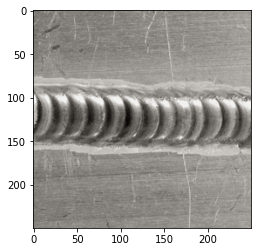

In [2]:
image = cv2.imread('./data/weld1.jpeg')
plt.imshow(image)

### 노이즈 데이터 추가

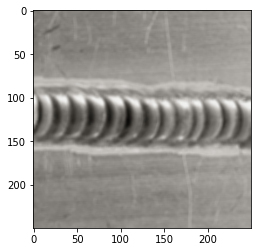

In [3]:
# 블러 - 실행할 때마다 랜덤 숫자를 생성하여 블러를 넣습니다.
def blur(image):
    filtersize = random.randrange(3,11)
    low_pass_filter = np.ones((filtersize, filtersize), np.float32) / filtersize**2
    dst = cv2.filter2D(image, -1, low_pass_filter)
    return dst

blur_image = blur(image)
plt.imshow(blur_image)

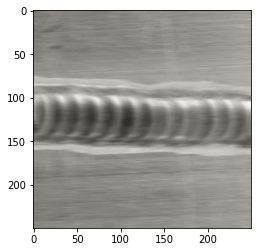

In [4]:
# 모션 블러 - 실행할 때마다 랜덤 숫자를 생성하여 움직이는 듯한 블러 효과를 줍니다.
def motion_blur(image):
    size = random.randrange(5,15)
    motion_blur = np.zeros((size, size))
    motion_blur[int((size-1)/2), :] = np.ones(size)
    motion_blur = motion_blur / size
    dst = cv2.filter2D(image, -1, motion_blur)
    
    return dst

motion_image = motion_blur(image)
plt.imshow(motion_image)

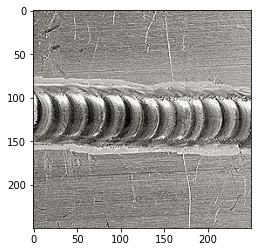

In [5]:
# 샤프닝 - 실행할 때마다 랜덤 숫자를 생성하여 샤프닝 효과를 줍니다.
def sharpening(image):
    rand = random.randrange(1,4)
    if rand == 1:
        mask = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    elif rand == 2:
        mask = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    else:
        mask = np.array([[-1, -1, -1, -1, -1],
                         [-1, 2, 2, 2, -1],
                         [-1, 2, 9, 2, -1],
                         [-1, 2, 2, 2, -1],
                         [-1, -1, -1, -1, -1]]) / 9.0
    dst = cv2.filter2D(image, -1, mask)
    return dst

sharpening_image = sharpening(image)
plt.imshow(sharpening_image)

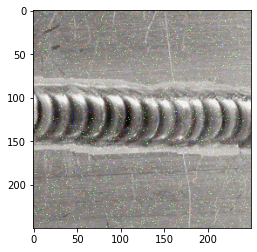

In [6]:
# 가우시안 노이즈 - 실행할 때마다 랜덤 숫자를 생성하여 가우시안 노이즈를 추가합니다.
def gaussian_noise(image):
    rand = random.randrange(0,11)*0.1+0.5
    gauss = np.random.normal(0,rand,image.size)
    gauss = gauss.reshape(image.shape[0],image.shape[1],image.shape[2]).astype('uint8')
    # Add the Gaussian noise to the image
    image_gauss = cv2.add(image,gauss)
    return image_gauss
gaussian_image = gaussian_noise(image)
plt.imshow(gaussian_image)

### 노이즈 데이터 생성
위에서 확인한 노이즈 생성 모듈을 사용하여, 정상-비정상 데이터셋을 생성합니다.

In [7]:
# 위에서 확인한 노이즈 생성 함수들을 랜덤으로 호출하여 노이즈 데이터를 생성하고, 동일한 개수의 원본 데이터를 복제하여 데이터셋을 생성합니다.
def generate_data(number):
    duplicated_original_images = []
    noise_images = []
    data = []
    label = []
    for i in range(number):
        idx = random.randrange(1,5)
        if idx == 1:
            img = blur(image)
        elif idx == 2:
            img = motion_blur(image)
        elif idx == 3:
            img = sharpening(image)
        else:
            img = gaussian_noise(image)
        
        duplicated_original_images.append(image)
        noise_images.append(img)
        data.append(image)
        label.append(0)
        data.append(img)
        label.append(1)
    return duplicated_original_images, noise_images, np.array(data), np.array(label)

normal, abnormal, data, label = generate_data(200)

### 생성한 데이터셋(정상 - 비정상) 중 각 5개씩만 출력해봅니다.

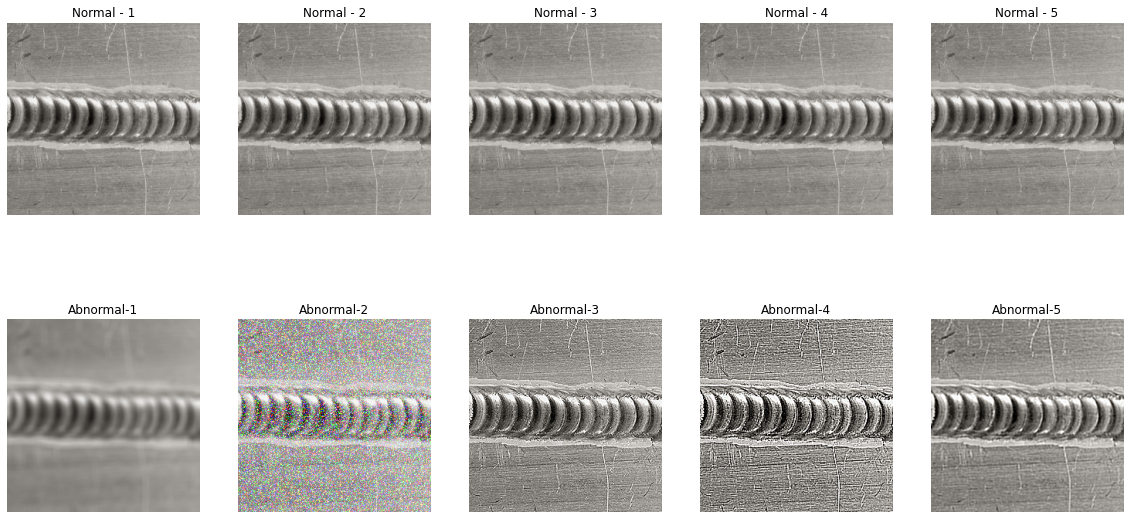

In [33]:
fig = plt.figure(figsize=(20,10))
rows = 2
cols = 5

for i in range(5): # 정상 데이터 5개 출력
    ax = fig.add_subplot(rows,cols,i+1)
    ax.imshow(normal[i])
    ax.set_title("Normal - "+ str(i+1))
    ax.axis("off")
    
for i in range(5): # 비정상 데이터 5개 출력
    ax = fig.add_subplot(rows,cols,i+6)
    ax.imshow(abnormal[i])
    ax.set_title("Abnormal-"+ str(i+1))
    ax.axis("off")
 
plt.show()


## 분류 모델 학습

In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
print(tf.__version__)

2.4.0-rc0


In [11]:
data.shape

(400, 250, 250, 3)

In [12]:
label.shape

(400,)

In [13]:
num_data = len(data)
print(num_data)
inputs_train, inputs_test, inputs_validate = np.split(data, [int(num_data*0.4), int(num_data*0.7)])
outputs_train, outputs_test, outputs_validate = np.split(label, [int(num_data*0.4), int(num_data*0.7)])

400


In [14]:
inputs_validate.shape

(120, 250, 250, 3)

In [15]:
outputs_validate.shape

(120,)

In [16]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=(250,250,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 492032)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               49203300  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 49,204,297
Trainable params: 49,204,297
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [20]:
hist = model.fit(inputs_train, outputs_train, validation_data = (inputs_test, outputs_test), epochs = 10, batch_size = 10)

Epoch 1/10
16/16 [==============================] - 4s 248ms/step - loss: 3974.5758 - accuracy: 0.4875 - val_loss: 201.8020 - val_accuracy: 0.5000
Epoch 2/10
16/16 [==============================] - 3s 201ms/step - loss: 115.4856 - accuracy: 0.5898 - val_loss: 30.5545 - val_accuracy: 0.6917
Epoch 3/10
16/16 [==============================] - 3s 200ms/step - loss: 21.3357 - accuracy: 0.5624 - val_loss: 1.6827e-06 - val_accuracy: 1.0000
Epoch 4/10
16/16 [==============================] - 3s 203ms/step - loss: 16.2129 - accuracy: 0.7558 - val_loss: 2.0347 - val_accuracy: 0.9083
Epoch 5/10
16/16 [==============================] - 3s 201ms/step - loss: 0.6985 - accuracy: 0.9082 - val_loss: 0.5810 - val_accuracy: 0.9417
Epoch 6/10
16/16 [==============================] - 3s 202ms/step - loss: 1.2986 - accuracy: 0.9218 - val_loss: 2.3842e-07 - val_accuracy: 1.0000
Epoch 7/10
16/16 [==============================] - 3s 203ms/step - loss: 1.4081 - accuracy: 0.9101 - val_loss: 4.9269e-04 - val_a

## 모델 성능 테스트
### 생성된 모델에 5개의 validation 데이터를 넣어 확인해봅니다.
- 0은 노이즈가 없는 원본, 1은 노이즈가 있음을 의미합니다.
- 모델을 통해 출력된 예측값(Predict)과 실제값(Label)이 일치함을 확인할 수 있습니다.

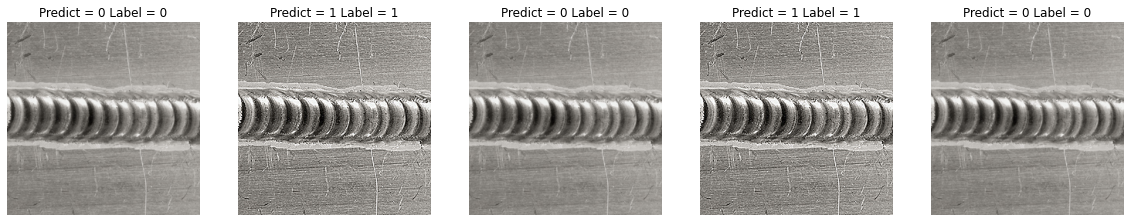

In [44]:
fig = plt.figure(figsize=(20,5))
rows = 1
cols = 5

for i in range(5): # 정상 데이터 5개 출력
    ax = fig.add_subplot(rows,cols,i+1)
    input_image = inputs_validate[i]
    label = outputs_validate[i]
    ax.imshow(input_image)
    reshape_image = input_image.reshape(-1,250,250,3)
    pred = model.predict(reshape_image)
    pred = int(pred[0][0])
    ax.set_title("Predict = " + str(pred) + " Label = "+ str(label))
    ax.axis("off")
    
plt.show()